## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Богатенкова Анастасия Олеговна

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

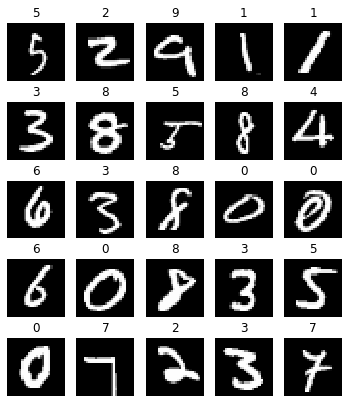

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)
    print(weight.std())

def init_layer_uni(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-np.sqrt(std**2 * 12) / 2, np.sqrt(std**2 * 12) / 2)
    print(weight.flatten().std())
    
def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28 * 28, 100)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

tensor(0.1000)


In [7]:
layers = []
sizes = [28 * 28] + [500] * 10 + [10]
for size, next_size in zip(sizes, sizes[1:]):
    layer = nn.Linear(size, next_size)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    #init_layer_uni(layer, 0.0, np.sqrt(2.0 / (size + next_size)))
    init_layer(layer, 0.0, 0.1)

    layers.append(layer)
    layers.append(nn.Tanh())
    #layers.append(nn.Sigmoid())

module = nn.Sequential(*layers)
module

tensor(0.0998)
tensor(0.1000)
tensor(0.0999)
tensor(0.1000)
tensor(0.1001)
tensor(0.1001)
tensor(0.0998)
tensor(0.0998)
tensor(0.1002)
tensor(0.1002)
tensor(0.0994)


Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=10, bias=True)
  (21): Tanh()
)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [8]:
#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = module(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9840089678764343
forward 0.8453929424285889
forward 0.7883910536766052
forward 0.770614743232727
forward 0.7667604088783264
forward 0.7665227651596069
forward 0.7652256488800049
forward 0.7634217739105225
forward 0.7617539763450623
forward 0.7631916999816895
forward 0.762965977191925
backward 0.01697077602148056
backward 0.005381998606026173
backward 0.00566148804500699
backward 0.005887222476303577
backward 0.00650908425450325
backward 0.0073686931282281876
backward 0.008330379612743855
backward 0.009858794510364532
backward 0.011289318092167377
backward 0.012688939459621906
backward 0.01302367728203535


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [9]:
def init_xavier(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def init_xavier_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)

def init_he(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    d = 2 / weight.size()[1]
    weight.normal_(mean=0, std=np.sqrt(d))
    
def make_network(activation_func, init_func):
    layers = []
    sizes = [28 * 28] + [500] * 10 + [10]
    for size, next_size in zip(sizes, sizes[1:]):
        layer = nn.Linear(size, next_size)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_func(layer)
        layers.append(layer)
        layers.append(activation_func)
    return nn.Sequential(*layers)

In [10]:
# tanh + xavier 
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
network = make_network(nn.Tanh(), init_xavier_uni)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9840089678764343
forward 0.64780193567276
forward 0.4986748993396759
forward 0.408786803483963
forward 0.3570474088191986
forward 0.3192192614078522
forward 0.2945311963558197
forward 0.27547529339790344
forward 0.2583715319633484
forward 0.24298426508903503
forward 0.22970564663410187
backward 0.020654501393437386
backward 0.017261477187275887
backward 0.016321131959557533
backward 0.015292712487280369
backward 0.013854768127202988
backward 0.012437435798346996
backward 0.011075805872678757
backward 0.010070540010929108
backward 0.008472474291920662
backward 0.006562821567058563
backward 0.003975017461925745


In [11]:
# relu + xavier
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
network = make_network(nn.ReLU(), init_xavier_uni)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9840089678764343
forward 0.6197094321250916
forward 0.44723033905029297
forward 0.2961232662200928
forward 0.20439864695072174
forward 0.1459263116121292
forward 0.10377863049507141
forward 0.07386139035224915
forward 0.052951253950595856
forward 0.03908231109380722
forward 0.02925136499106884
backward 0.04175323620438576
backward 0.006895137019455433
backward 0.004450872074812651
backward 0.0030278884805738926
backward 0.0019170079613104463
backward 0.00128041987773031
backward 0.0009036583942361176
backward 0.0005637940485030413
backward 0.00035194415249861777
backward 0.0002330892748432234
backward 0.0001538267097203061


In [12]:
# tanh + he
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
network = make_network(nn.Tanh(), init_he)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9840089678764343
forward 0.7111636400222778
forward 0.6284854412078857
forward 0.5919860005378723
forward 0.5741670727729797
forward 0.5632147789001465
forward 0.5595691204071045
forward 0.5566160082817078
forward 0.5533884167671204
forward 0.5579498410224915
forward 0.5584952235221863
backward 0.02726043574512005
backward 0.01074698381125927
backward 0.010627075098454952
backward 0.010933144018054008
backward 0.011652658693492413
backward 0.011380981653928757
backward 0.010775304399430752
backward 0.010129769332706928
backward 0.009469825774431229
backward 0.00930004846304655
backward 0.007283955812454224


In [13]:
# relu + he
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
network = make_network(nn.ReLU(), init_he)
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9840089678764343
forward 0.8104156851768494
forward 0.8120877146720886
forward 0.8332533836364746
forward 0.8200498819351196
forward 0.8044248223304749
forward 0.8248321413993835
forward 0.7782395482063293
forward 0.7665729522705078
forward 0.8085790872573853
forward 0.8314470648765564
backward 0.05207899212837219
backward 0.00799516960978508
backward 0.007399067748337984
backward 0.007122967392206192
backward 0.006243009120225906
backward 0.005983414128422737
backward 0.0053795683197677135
backward 0.004502791911363602
backward 0.0040818811394274235
backward 0.0038536014035344124
backward 0.003563552862033248


<i> 1.4 Сделайте выводы по первой части </i>

Для ReLu лучше подходит инициализация He, для Tanh - Xavier

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [14]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        w, b = self.linear.parameters()
        if self.training:
            mask = torch.zeros_like(w).bernoulli_(self.p) 
        else:
            mask = torch.ones_like(w) * self.p
        mask = mask.data
        output = torch.mm(x, (w * mask).transpose(0, 1)) + b
        return output

In [15]:
l = nn.Linear(10, 10)
list(l.parameters())

[Parameter containing:
 tensor([[ 0.1430,  0.1918,  0.1706,  0.1470,  0.0660, -0.0943,  0.2317,  0.1650,
           0.1680, -0.3091],
         [-0.0089, -0.2933, -0.1389, -0.2484, -0.0742, -0.2415, -0.0276, -0.1075,
           0.1535, -0.0105],
         [ 0.3141, -0.2539,  0.1416,  0.0814, -0.2731,  0.0416,  0.0518, -0.0531,
           0.0050,  0.0327],
         [ 0.0586,  0.2251, -0.1946, -0.0143, -0.0962, -0.0044,  0.3133,  0.1023,
          -0.0341, -0.2393],
         [ 0.2311, -0.2834, -0.2897, -0.0224, -0.2843, -0.1290,  0.1325,  0.2663,
           0.2462, -0.2181],
         [ 0.1416, -0.0651,  0.2399,  0.1571, -0.0041,  0.1549, -0.1572,  0.2986,
          -0.0591, -0.2391],
         [ 0.0807, -0.1240,  0.1842,  0.2782, -0.2126, -0.2566,  0.1605, -0.2176,
           0.0832, -0.1696],
         [ 0.2456,  0.0880, -0.0121, -0.1282, -0.2926,  0.1997,  0.0079, -0.0316,
           0.2082, -0.0575],
         [-0.1063,  0.1671, -0.1004, -0.1694,  0.0996,  0.1499,  0.3117,  0.1916,
       

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [16]:
# 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями

layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    layers.append(nn.Linear(size, next_size))  
    if next_size != 10:
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
    else:
        layers.append(nn.LogSoftmax())

net1 = nn.Sequential(*layers)

In [17]:
# 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев

layers = [nn.Flatten()]

sizes = [784, 200, 200, 10]
for size, next_size in zip(sizes, sizes[1:]):
    if next_size != 10:
        layers.append(DropConnect(size, next_size, 0.5))
        layers.append(nn.ReLU())
    else:
        layers.append(nn.Linear(size, next_size))
        layers.append(nn.LogSoftmax())

net2 = nn.Sequential(*layers)

Epoch 4... (Train/Test) NLL: 0.598/0.327	Accuracy: 0.849/0.923


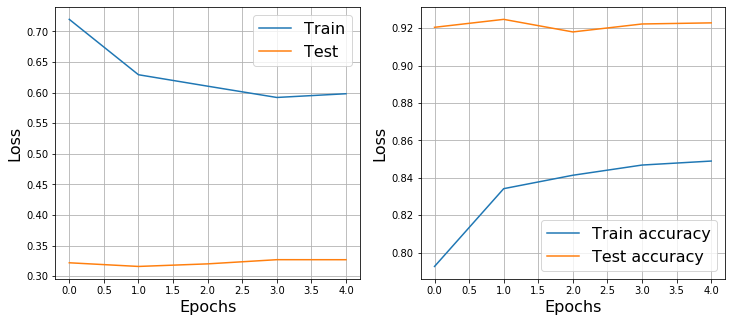

([0.7195149043094374,
  0.6290536473618388,
  0.6103743040231245,
  0.5919296147027758,
  0.5980098231641977],
 [0.32190219756168653,
  0.31591509150553354,
  0.3201286751258222,
  0.3269626135124436,
  0.3269094245720513],
 [0.7926106, 0.8342051, 0.84137905, 0.8468317, 0.8489694],
 [0.9204905, 0.9247429, 0.9180182, 0.9222706, 0.9228639])

In [18]:
from train_utils import train
train(net1, train_loader, test_loader, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.246/0.145	Accuracy: 0.934/0.959


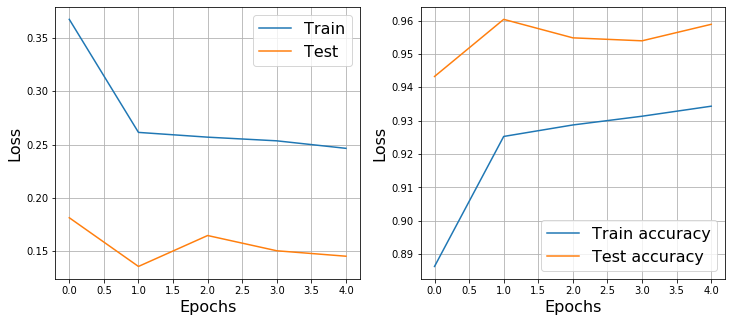

([0.36747878273603507,
  0.261431732125628,
  0.25695723930655767,
  0.25351456072189404,
  0.24646744837384743],
 [0.1813534414277801,
  0.13566764194188238,
  0.1646753125175645,
  0.15036503852734082,
  0.14526514626473566],
 [0.8863384, 0.9252732, 0.9287158, 0.9313311, 0.934335],
 [0.94323575, 0.96034414, 0.95480615, 0.95391613, 0.95886075])

In [19]:
from train_utils import train
train(net2, train_loader, test_loader, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Dropout 0.02: 0.963/0.955

Dropout 0.1: 0.944/0.958

Droput 0.5: 0.851/0.915

Dropconn 0.95: 0.961/0.959

Dropconn 0.9: 0.958/0.963

Dropconn 0.5: 0.934/0.950

Dropconn в целом показал результаты лучше, чем Dropout

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [23]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.043/0.077	Accuracy: 0.986/0.979


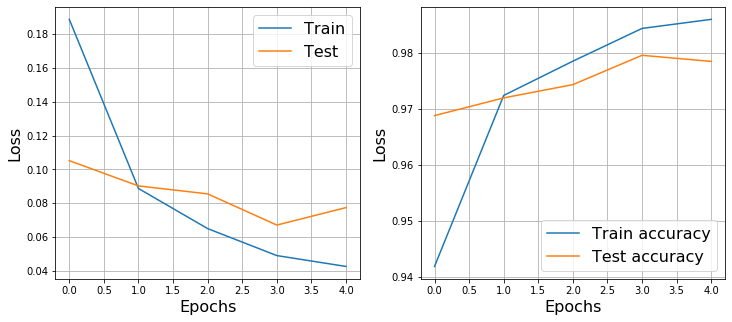

([0.1885869339712139,
  0.08873707233374116,
  0.06506649532150835,
  0.04912772132053987,
  0.04271180024603878],
 [0.10517402783130543,
  0.09024839922697342,
  0.08556117612538458,
  0.06714014853409762,
  0.07743756036212243],
 [0.94189215, 0.97245353, 0.9785781, 0.9844305, 0.9860519],
 [0.9688489, 0.9720135, 0.9743869, 0.97962815, 0.97854036])

In [21]:
# 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями

network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01, ravel_init=True)

Epoch 4... (Train/Test) NLL: 0.048/0.062	Accuracy: 0.984/0.981


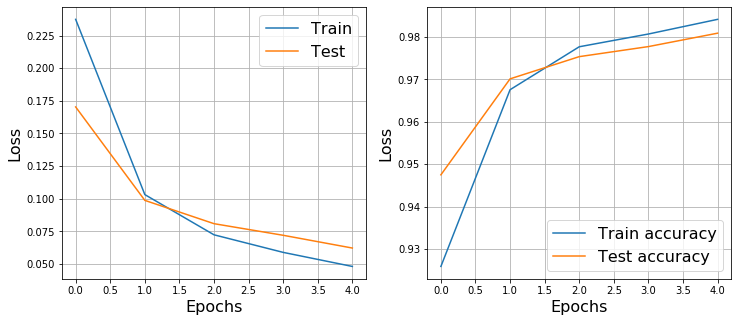

([0.2373888410611956,
  0.1031980643620782,
  0.07241367157111799,
  0.058956613611759565,
  0.048186528293896455],
 [0.1703218058034589,
  0.09877612698776057,
  0.08093410987359813,
  0.07204239874418024,
  0.06227244382511966],
 [0.9258673, 0.9675728, 0.9777064, 0.9807158, 0.9841751],
 [0.9474881, 0.9701345, 0.9753758, 0.9777492, 0.98091376])

In [25]:
# 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями

network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

Судя по результатам Layer Normalization показал себя на тесте немного лучше, чем Batch Normalization, на трейне наборот.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: